In [ ]:
#Set up and Read the data
import pandas as pd
import sqlite3


In [ ]:
# read csv file
df_Fact = pd.read_csv('/content/data.csv')


In [ ]:
df_Fact

,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
323620,565324,22852,DOG BOWL VINTAGE CREAM,2.0,09/02/2011 13:18,4.25,13232.0,United Kingdom
323621,565324,22853,CAT BOWL VINTAGE CREAM,1.0,09/02/2011 13:18,3.25,13232.0,United Kingdom
323622,565324,22816,CARD MOTORBIKE SANTA,24.0,09/02/2011 13:18,0.42,13232.0,United Kingdom
323623,565324,22818,CARD CHRISTMAS VILLAGE,24.0,09/02/2011 13:18,0.42,13232.0,United Kingdom


In [ ]:
# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()


In [ ]:
# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn)


323625

In [ ]:
df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
df_Fact1


,index,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
323620,323620,565324,22852,DOG BOWL VINTAGE CREAM,2.0,09/02/2011 13:18,4.25,13232.0,United Kingdom
323621,323621,565324,22853,CAT BOWL VINTAGE CREAM,1.0,09/02/2011 13:18,3.25,13232.0,United Kingdom
323622,323622,565324,22816,CARD MOTORBIKE SANTA,24.0,09/02/2011 13:18,0.42,13232.0,United Kingdom
323623,323623,565324,22818,CARD CHRISTMAS VILLAGE,24.0,09/02/2011 13:18,0.42,13232.0,United Kingdom


In [ ]:
# clean data and group transactions by Customerid
cleandata= pd.read_sql(''' SELECT customerid,
                   MAX(receiptdate) AS last_order_date,
                   COUNT(*) AS count_order,
                   SUM(unitprice*quantity) AS totalprice
            FROM data
            WHERE receiptno NOT LIKE '%C%'
            AND customerid IS NOT NULL
            AND unitprice != 0
            GROUP BY customerid ''', conn)

# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)



3327

In [ ]:
df_Fact2 = pd.read_sql('SELECT * FROM cleandata', conn)
df_Fact2


,index,CustomerID,last_order_date,count_order,totalprice
0,0,12346.0,1/18/2011 10:01,1,77183.60
1,1,12347.0,12/07/2010 14:57,124,2790.86
2,2,12348.0,12/16/2010 19:09,28,1487.24
3,3,12350.0,02/02/2011 16:01,17,334.40
4,4,12352.0,3/22/2011 16:08,38,1561.81
...,...,...,...,...,...
3322,3322,18280.0,03/07/2011 09:52,10,180.60
3323,3323,18281.0,06/12/2011 10:53,7,80.82
3324,3324,18282.0,08/05/2011 13:35,7,100.21
3325,3325,18283.0,7/14/2011 13:20,400,985.77


In [ ]:
df_Fact2.dtypes
df_Fact2['last_order_date'] = pd.to_datetime(df_Fact2['last_order_date'])
df_Fact2.dtypes


index                       int64
CustomerID                float64
last_order_date    datetime64[ns]
count_order                 int64
totalprice                float64
dtype: object

In [ ]:
# Create date variable that records recency
import numpy as np
import datetime
df_Fact2["last_order_date"] = df_Fact2["last_order_date"].dt.date
# Create snapshot date
snapshot_date = df_Fact2['last_order_date'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Aggregate data by each customer
customers = df_Fact2.groupby(['CustomerID']).agg({
   'last_order_date': lambda x: (snapshot_date - x.max()).days,
   'count_order':'sum' ,
   'totalprice': 'sum'})

2011-01-10


In [ ]:
# Rename columns
customers.rename(columns = {'last_order_date': 'Recency',
                            'count_order': 'Frequency',
                            'totalprice': 'MonetaryValue'}, inplace=True)

In [ ]:
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,34,31,711.79
12348.0,25,17,892.80
12370.0,24,91,1868.02
12377.0,21,43,1001.52
12383.0,19,37,600.72
...,...,...,...
18245.0,22,27,365.73
18259.0,33,7,376.30
18260.0,25,11,230.70


Text(0.5, 1.0, 'Histogram and Recency')

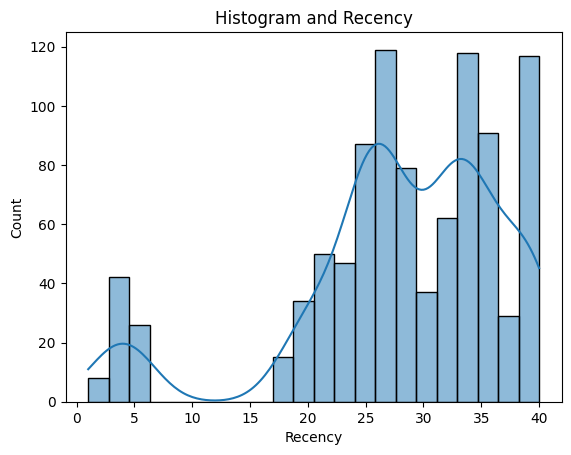

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Recency', kde=True)
ax.set_title('Histogram and Recency')

Text(0.5, 1.0, 'Histogram and Frequency')

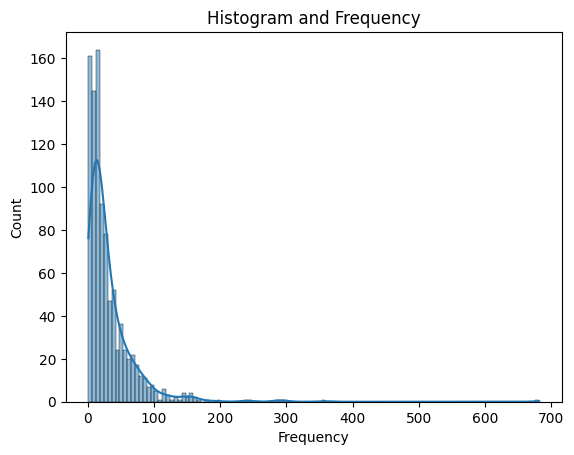

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Frequency', kde=True)
ax.set_title('Histogram and Frequency')

Text(0.5, 1.0, 'Histogram and MonetaryValue')

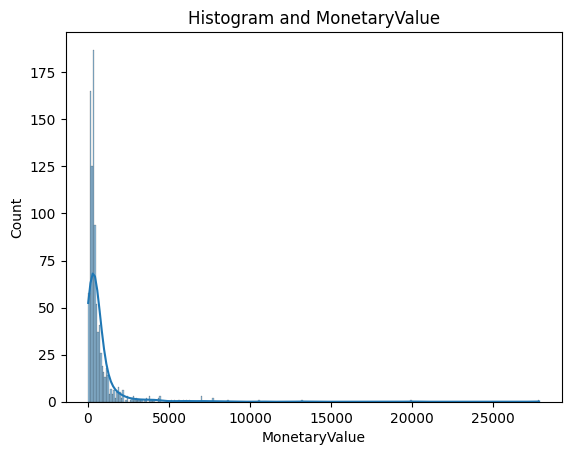

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='MonetaryValue', kde=True)
ax.set_title('Histogram and MonetaryValue')

<ipython-input-16-a7e08f6e9151>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
<ipython-input-16-a7e08f6e9151>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
<ipython-input-16-a7e08f6e9151>:8: UserWarni

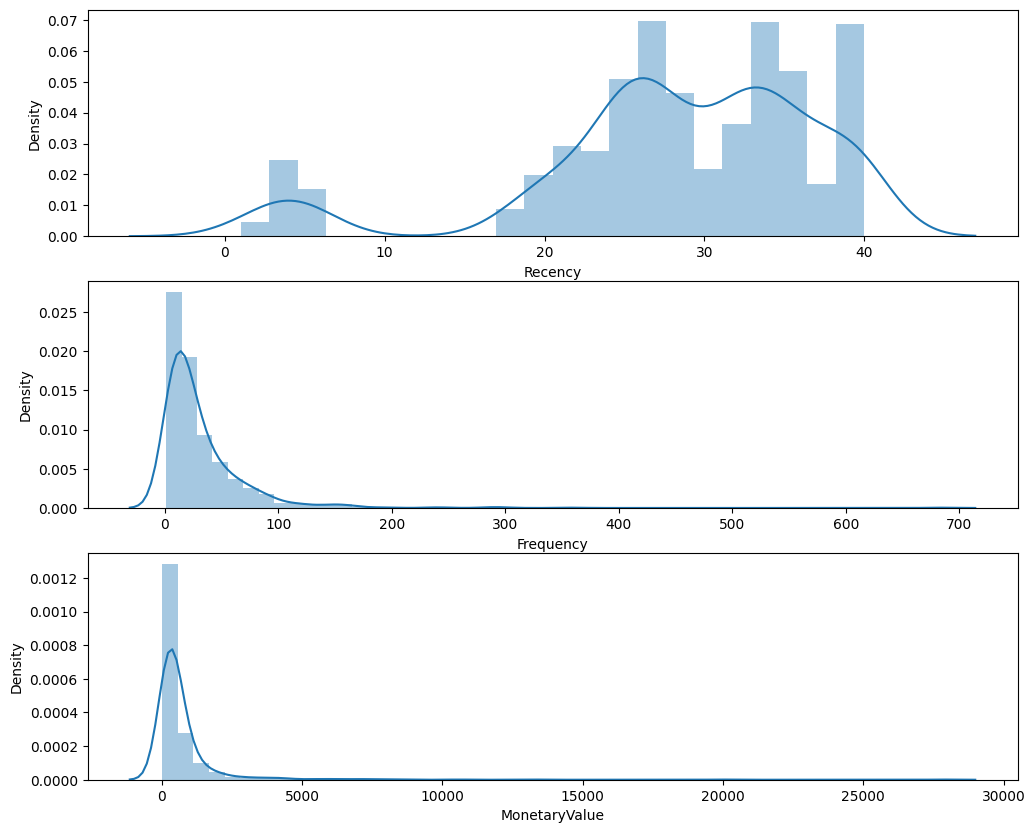

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue
956,111.218123,4.017040,4.062880
957,221.899066,2.183842,4.075660
958,138.305705,2.765861,3.849193
959,221.899066,2.183842,3.695944
960,5.605632,5.162625,3.468982


<ipython-input-18-edbcbb4b2927>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
<ipython-input-18-edbcbb4b2927>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
<ipython-input-18-edbcbb4b2927>:8: U

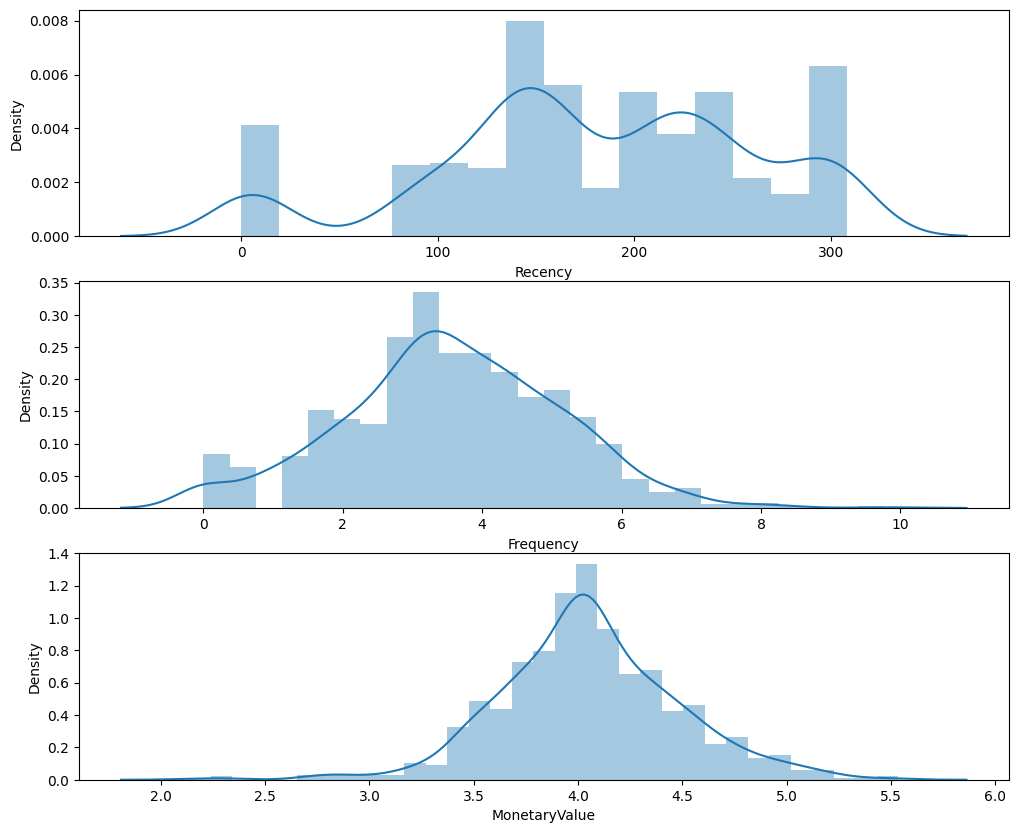

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers_fix['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0. -0.]
[1. 1. 1.]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

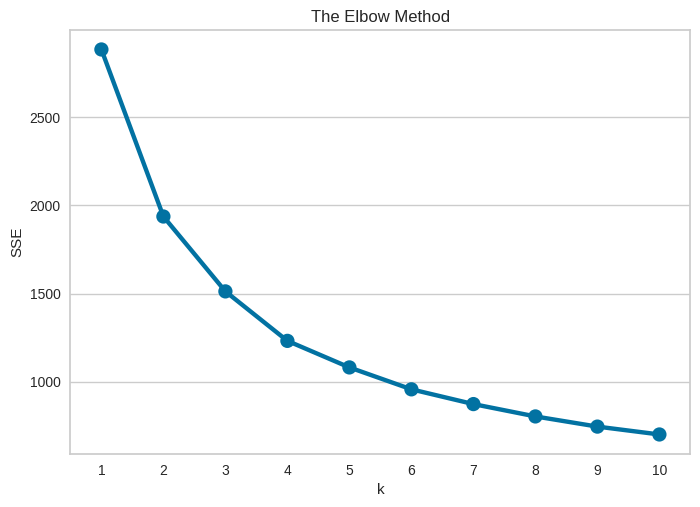

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

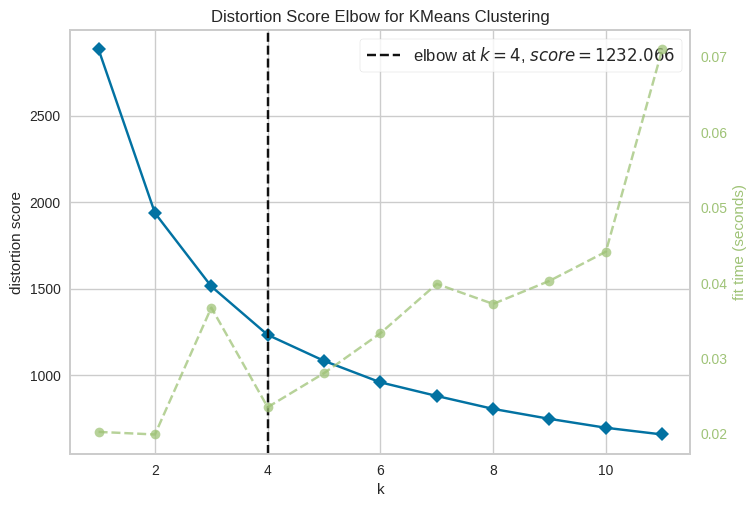

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue
Cluster,,,
0,200,200,200
1,180,180,180
2,275,275,275
3,306,306,306


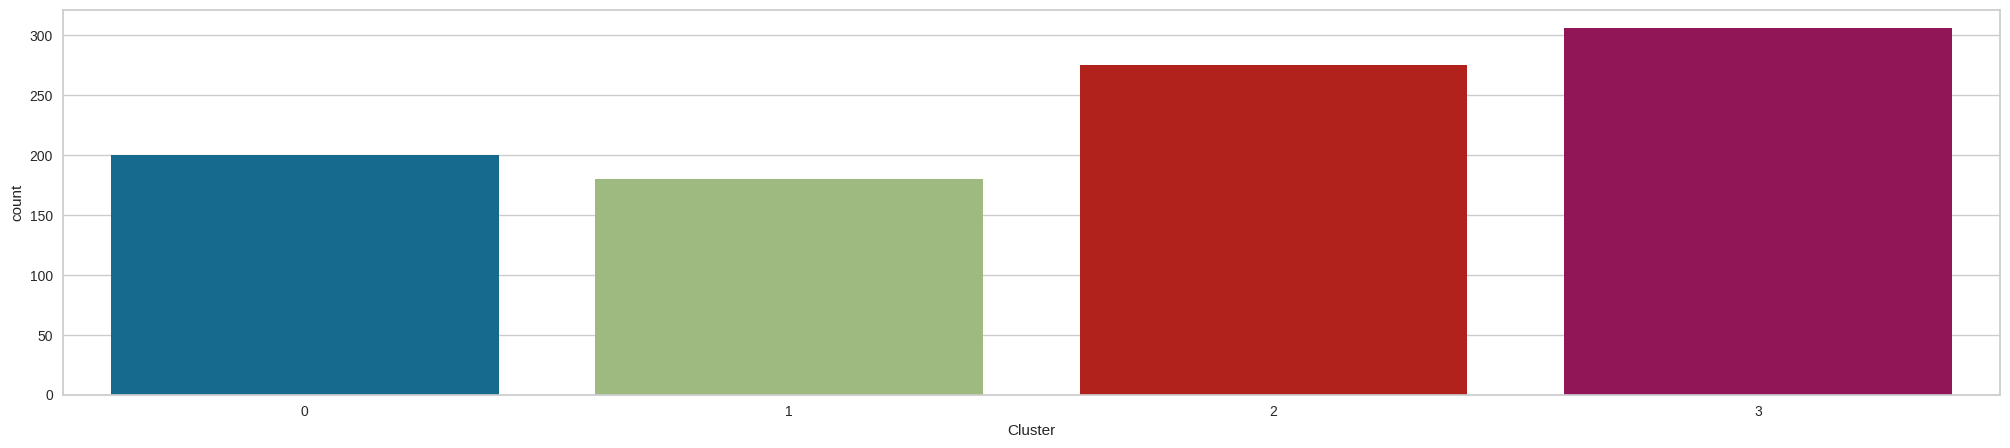

In [ ]:

model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         24.80     78.13       2024.79   200
1         32.92      5.78        163.19   180
2         19.72     18.09        392.46   275
3         34.99     29.62        448.50   306

In [ ]:
customers

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,34,31,711.79,3
12348.0,25,17,892.80,2
12370.0,24,91,1868.02,0
12377.0,21,43,1001.52,0
12383.0,19,37,600.72,2
...,...,...,...,...
18245.0,22,27,365.73,2
18259.0,33,7,376.30,3
18260.0,25,11,230.70,2


<Axes: xlabel='Attribute', ylabel='Value'>

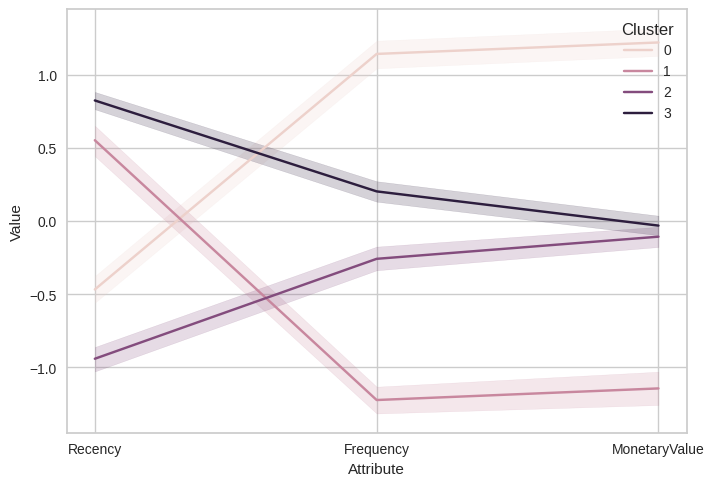

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x = 'Attribute', y= 'Value', hue='Cluster', data=df_nor_melt)